In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
from itertools import chain
from collections import Counter
from PIL import Image
from tqdm import tqdm
import time
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models.resnet import resnet18
from torchvision.models.densenet import densenet121
from torchvision.models.mobilenetv2 import mobilenet_v2
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchsummary import summary

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
seed = 17167055
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
root = 'dataset'
dataset = [str(data) for data in list(chain(*[i.glob('*') for i in Path(root).glob('*')]))]
print(f'Total data: {len(dataset)}')

Total data: 4092


In [97]:
def img_loader(path):
    with open(path, 'rb') as f:
        return Image.open(f).convert('RGB')
#     .resize((224, 224))

In [5]:
images = [img_loader(i) for i in dataset]
labels = [i.split('\\')[-2] for i in dataset]

assert len(images)==len(labels)
assert len(images)==len(dataset)

In [6]:
scaler = LabelEncoder()
labels = scaler.fit_transform(labels)

In [7]:
Counter(labels).most_common()

[(0, 2162), (1, 1930)]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=seed)
print(f'Train: {len(X_train)}')
print(f'Validation: {len(X_val)}')
print(f'Test: {len(X_test)}')

Train: 2454
Validation: 819
Test: 819


In [9]:
label, count = np.unique(labels, return_counts=True)

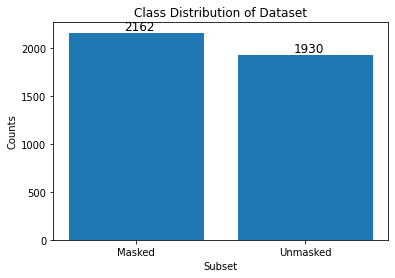

In [10]:
# plt.figure(figsize=(5, 5))
plt.bar(['Masked', 'Unmasked'], count)
for index, value in enumerate(count):
    plt.text(index-0.07, value+25, str(value), fontsize=12)
plt.xlabel('Subset')
plt.ylabel('Counts')
plt.title('Class Distribution of Dataset')
plt.show()

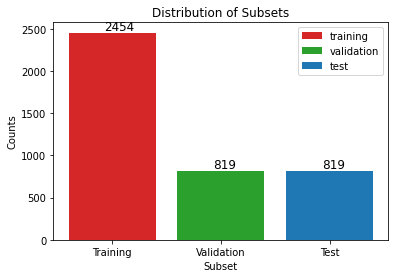

In [11]:
count = [len(X_train), len(X_val), len(X_test)]
plt.bar('Training', count[0], color='tab:red', label='training')
plt.bar('Validation', count[1], color='tab:green', label='validation')
plt.bar('Test', count[2], color='tab:blue', label='test')
for index, value in enumerate(count):
    plt.text(index-0.07, value+25, str(value), fontsize=12)
plt.xlabel('Subset')
plt.ylabel('Counts')
plt.title('Distribution of Subsets')
plt.legend()
plt.show()

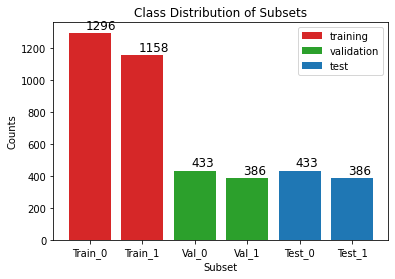

In [12]:
label, train_count = np.unique(y_train, return_counts=True)
label, val_count = np.unique(y_val, return_counts=True)
label, test_count = np.unique(y_test, return_counts=True)
count = np.concatenate((train_count, val_count, test_count))
plt.bar(['Train_0', 'Train_1'], train_count, color='tab:red', label='training')
plt.bar(['Val_0', 'Val_1'], val_count, color='tab:green', label='validation')
plt.bar(['Test_0', 'Test_1'], test_count, color='tab:blue', label='test')
for index, value in enumerate(count):
    plt.text(index-0.07, value+25, str(value), fontsize=12)
plt.xlabel('Subset')
plt.ylabel('Counts')
plt.title('Class Distribution of Subsets')
plt.legend()
plt.show()

In [13]:
class MaskDataset(Dataset):
    def __init__(self, X, y, transform):
        self.image = X
        self.label = y
        self.transform = transform
        
    def __getitem__(self, idx):
        img = self.image[idx]
        lbl = self.label[idx]
        if self.transform:
            img = self.transform(img)
        return img, lbl
    
    def __len__(self):
        return len(self.image)

In [14]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAutocontrast(),
    transforms.RandomAdjustSharpness(2),
    transforms.ToTensor(),
])

transform_valtest = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

In [29]:
trainset = MaskDataset(X_train, y_train, transform_train)
trainloader = DataLoader(trainset, batch_size=16, shuffle=False)

valset = MaskDataset(X_val, y_val, transform_valtest)
valloader = DataLoader(valset, batch_size=1, shuffle=False)

testset = MaskDataset(X_test, y_test, transform_valtest)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

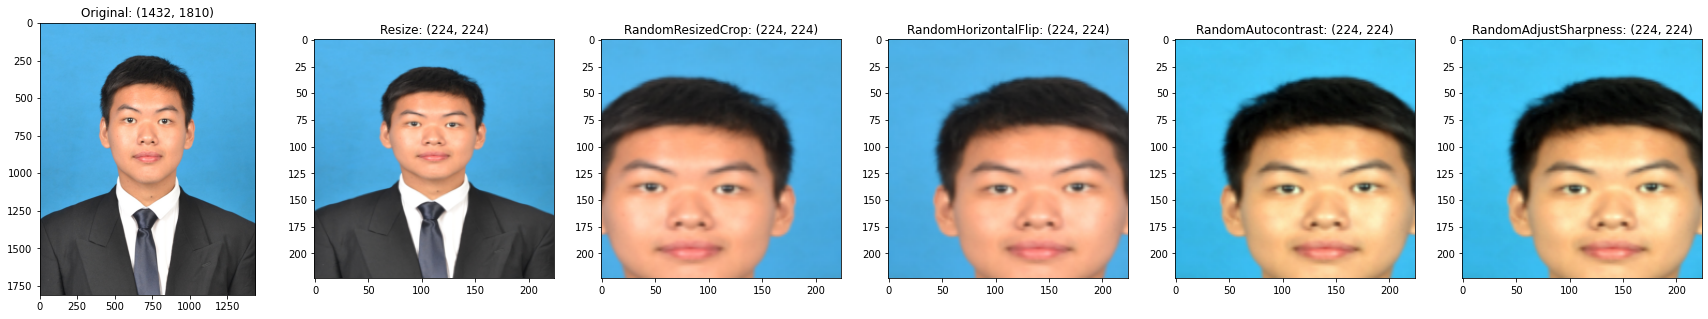

In [116]:
img = img_loader('demo/self-nomask.jpg')
plt.figure(figsize=(30, 5))
plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title(f'Original: {img.size}')
plt.subplot(1, 6, 2)
img = transforms.Resize((224,224))(img)
plt.imshow(img)
plt.title(f'Resize: {img.size}')
plt.subplot(1, 6, 3)
img = transforms.RandomResizedCrop(224)(img)
plt.imshow(img)
plt.title(f'RandomResizedCrop: {img.size}')
plt.subplot(1, 6, 4)
img = transforms.RandomHorizontalFlip()(img)
plt.imshow(img)
plt.title(f'RandomHorizontalFlip: {img.size}')
plt.subplot(1, 6, 5)
img = transforms.RandomAutocontrast()(img)
plt.imshow(img)
plt.title(f'RandomAutocontrast: {img.size}')
plt.subplot(1, 6, 6)
img = transforms.RandomAdjustSharpness(2)(img)
plt.imshow(img)
plt.title(f'RandomAdjustSharpness: {img.size}')
plt.show()